<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Function-for-generating-trajectories" data-toc-modified-id="Function-for-generating-trajectories-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Function for generating trajectories</a></span></li><li><span><a href="#Generate-some-schematic-trajectories" data-toc-modified-id="Generate-some-schematic-trajectories-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate some schematic trajectories</a></span></li></ul></div>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [22]:
# import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [5]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Helvetica'

In [6]:
# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

In [7]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'
yellow = '#ffffd4'

In [8]:
cb_blue1 = '#a6cee3'
cb_blue2 = '#1f78b4'
cb_green1 = '#b2df8a'
cb_green2 = '#33a02c'
cb_pink = '#fb9a99'
cb_red = '#e31a1c'
cb_orange1 = '#fdbf6f'
cb_orange2 = '#ff7f00'
cb_purple1 = '#cab2d6'
cb_purple2 = '#6a3d9a'

In [9]:
mutation_number_colors = {1: ['#2272b6', '#9ecae1'], 
                          2: ['#41ab5d']}

# Function for generating trajectories

In [10]:
T=1000 #total timesteps
dt=0.1 #time interval i.e. 0.1 = 10% of 1 year (1000 timesteps = 100 years)
effective_depth=2000

In [11]:
#function that maps clone trajectories back onto allele trajectories and compares to observed allele trajectories to assign likelihood
def clone_trajectories_generator(clones, T, dt, effective_depth): #upper_freq = upper VAF (or cell fraction) to allow the likelihood to include
    #e.g. clones={('DNMT3A_p.Q606X'):{'fitness':0.67, 'est_time':60}, ('DNMT3A_p.Q606X', 'SF3B1_p.K700E'):{'fitness':0.67, 'est_time':62.}}
    
    for k, v in clones.items():
        s=v['fitness']
        tau=v['est_time']
        clone_size_trajectory=np.array([(1/s)*((np.exp(s*(i*dt-tau)))-1) for i in range(T)])
        clone_size_trajectory=np.where(clone_size_trajectory < 0, 0.0, clone_size_trajectory)
        v['clone_size_trajectory']=clone_size_trajectory #adds clone_size_trajectory to the clones dictionary

    total_clone_size=np.array([1.0*10**5 for i in range(T)]) #N = 10**5
    for k, v in clones.items():
        clone_size_trajectory=v['clone_size_trajectory']
        total_clone_size+=clone_size_trajectory
        
    for k, v in clones.items():
        clone_size_trajectory=v['clone_size_trajectory']
        clone_frequency_trajectory=clone_size_trajectory/total_clone_size
        v['clone_frequency_trajectory']=clone_frequency_trajectory #taking in to account changing N size (from other clones)
        
        for age, freq in zip(np.linspace(0, T*dt, T), clone_frequency_trajectory):
            if freq >= 1/(1*10**5):
                establishment_age = age
                break
                
        v['establishment_time']=establishment_age
    
        
    mean_population_fitness = {}
    for k, v in clones.items():
        fitness = v['fitness']
        t=0
        for frequency in v['clone_frequency_trajectory']:
            if t in mean_population_fitness.keys():
                mean_population_fitness[t].append((frequency, frequency*fitness))
            else:
                mean_population_fitness[t]=[(frequency, frequency*fitness)]
            t+=1
            
    overall_mean_population_fitness = []
    for timepoint, v in mean_population_fitness.items():
        total_cell_fraction = 0
        total_mean_clone_fitness = 0
        for clone in v:
            cell_fraction = clone[0]
            mean_clone_fitness = clone[1]
            total_cell_fraction+=cell_fraction
            total_mean_clone_fitness+=mean_clone_fitness
    #     wildtype_cell_fraction = 1-total_cell_fraction
    #     total_mean_clone_fitness+=(0*wildtype_cell_fraction)
        overall_mean_population_fitness.append(total_mean_clone_fitness)
        
    mutation_trajectories={}
    for k, v in clones.items():
        clone_frequency_trajectory=v['clone_frequency_trajectory']

        for mutation in k:
            if mutation in mutation_trajectories:
                mutation_trajectories[mutation]+=clone_frequency_trajectory
            else: #if mutation not in mutation_trajectories
                mutation_trajectories[mutation]=clone_frequency_trajectory
                
    return clones, mutation_trajectories, mean_population_fitness, overall_mean_population_fitness

# Generate some schematic trajectories

In [12]:
def plot_trajectories(clones, clone_trajectories, mutation_trajectories, mean_population_fitness, save_name):
    fig, axes = plt.subplots(2, 1, figsize = (6, 6), sharex = True, gridspec_kw={'height_ratios': [1, 1.75], 'hspace': 0.3})
    
    ax1 = axes[0]
    ax2 = axes[1]
    
    fitnesses = []

    #PLOT THE TRAJECTORIES
    number_mutations_plotted = {}

    for variant, trajectory in mutation_trajectories.items():
        for clone in clones.keys():
            if variant in clone:
                number_mutations = clone.index(variant)+1

        if number_mutations in number_mutations_plotted.keys():
            mutation_color = mutation_number_colors[number_mutations][number_mutations_plotted[number_mutations]]
            number_mutations_plotted[number_mutations]+=1
        else:
            mutation_color = mutation_number_colors[number_mutations][0]
            number_mutations_plotted[number_mutations]=1

        ax2.plot(np.linspace(0, 100, 1000), trajectory, linewidth=3, color=mutation_color, zorder = 10)    
        
    #PLOT THE FITNESSES
    #mean population fitness:
    ax1.plot(np.linspace(0, 100, 1000), [i*100 for i in mean_population_fitness], linewidth=3, color=grey5, zorder = 50) 
    
    #individual clone fitnesses:
    number_mutations_plotted = {}
    
    for k, v in clones.items():
        print(clone)
        fitness = v['fitness']
        fitnesses.append(fitness)
        for clone, info in clone_trajectories.items():
            if clone ==k:
                est_time = info['establishment_time']
                print('establishment time for '+str(k)+' = '+str(est_time))
#         est_time = v['establishment_time']
        number_mutations = len(k)
        if number_mutations in number_mutations_plotted.keys():
            mutation_color = mutation_number_colors[number_mutations][number_mutations_plotted[number_mutations]]
            number_mutations_plotted[number_mutations]+=1
        else:
            mutation_color = mutation_number_colors[number_mutations][0]
            number_mutations_plotted[number_mutations]=1
            
        v['cross population fitness'] = 1000
        for i in mean_population_fitness:
            if i >=fitness:
                v['cross population fitness']=mean_population_fitness.index(i)
                break
                
        time_crosses_population_fitness = v['cross population fitness']/10
                        
        ax1.plot([est_time, 100], [fitness*100, fitness*100], linewidth=3, color=mutation_color, zorder = 10)
        ax1.scatter([est_time, 100], [fitness*100, fitness*100], color=mutation_color, zorder = 10)
        ax1.plot([time_crosses_population_fitness, time_crosses_population_fitness], [0, max(mean_population_fitness)*115], linewidth=3, color=mutation_color, zorder = 10, linestyle = ':')
        ax2.plot([time_crosses_population_fitness, time_crosses_population_fitness], [0, 1.0], linewidth=3, color=mutation_color, zorder = 10, linestyle = ':')
        
        clone_name = ' '
        for i in k:
            clone_name+=i
            clone_name+='+'
        clone_name = clone_name[:-1]
        ax1.annotate(clone_name, (86, fitness*100), va = 'center', ha = 'left', color = mutation_color, fontsize = 24)
        
    print(fitnesses)

    #FORMAT THE PLOT
    for ax in [ax1]:
        ax.set_ylim(0, max(fitnesses)*115)
        ax.set_ylabel('fitness (%)', fontsize = 24)
        if max(fitnesses)<0.25:
            ax.yaxis.set_major_locator(MultipleLocator(5))
        if 0.25<max(fitnesses)<0.5:
            ax.yaxis.set_major_locator(MultipleLocator(10))
        if max(fitnesses)>0.5:
            ax.yaxis.set_major_locator(MultipleLocator(20))
    
    for ax in [ax2]:
        ax.set_yscale('log')
        y_major_ticks = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
        y_major_tick_labels = ["0.001%", "0.01%", "0.1%", "1%", "10%", "100%"]
        ax.set_yticks(y_major_ticks)
        ax.set_yticklabels(y_major_tick_labels)   
        ax.set_ylim(0.00001, 1.2)
        ax.set_xlabel('age', fontsize = 24)
        ax.set_ylabel('fraction of cells (%)', fontsize = 24)
        
    for ax in axes.flatten():
        ax.set_xlim(0, 86)
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.set_title('')
        ax.grid(axis = 'y', which = 'both', zorder = 0, linestyle = ':')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis = 'both', which='major', length=6, width=1.5, color = '#969696')
        ax.tick_params(axis = 'both', which='minor', length=4, width=1.5, color = '#969696')
        ax.tick_params(axis='both', which='major', labelsize=24)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(1.5)
            ax.spines[axis].set_color(grey3)

    plt.tight_layout()
            
    return plt.show()

('s1',)
establishment time for ('s1',) = 5.005005005005005
[0.15]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


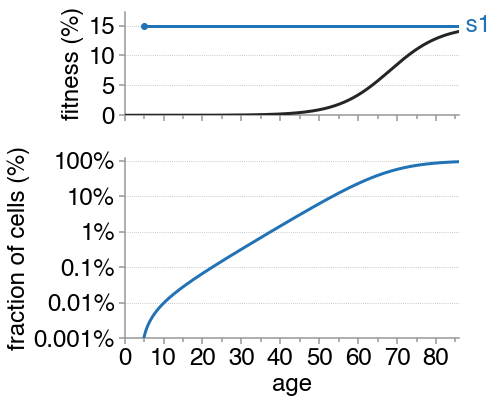

In [19]:
clones={('s1',):{'fitness':0.15, 'est_time': 4}}
clone_trajectories, mutation_trajectories, mean_population_fitness, overall_mean_population_fitness = clone_trajectories_generator(clones, T, dt, effective_depth)
plot_trajectories(clones, clone_trajectories, mutation_trajectories, overall_mean_population_fitness, 'single_mutation')

('s2',)
establishment time for ('s1',) = 5.005005005005005
('s2',)
establishment time for ('s2',) = 10.01001001001001
[0.15, 0.3]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


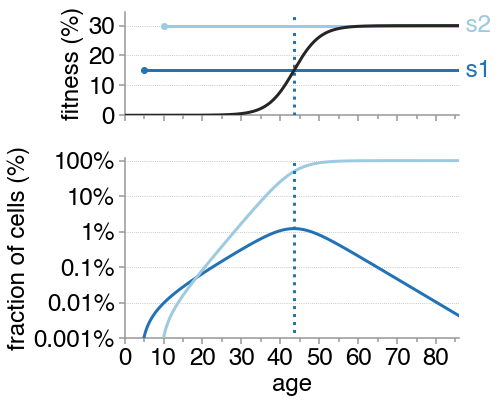

In [20]:
clones={('s1',):{'fitness':0.15, 'est_time': 4}, ('s2',):{'fitness':0.3, 'est_time':9.1}}
clone_trajectories, mutation_trajectories, mean_population_fitness, overall_mean_population_fitness = clone_trajectories_generator(clones, T, dt, effective_depth)
plot_trajectories(clones, clone_trajectories, mutation_trajectories, overall_mean_population_fitness, 'two_mutations')

('s1', 's3')
establishment time for ('s1',) = 5.005005005005005
('s1', 's3')
establishment time for ('s2',) = 10.01001001001001
('s1', 's3')
establishment time for ('s1', 's3') = 50.050050050050054
[0.15, 0.3, 0.9]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


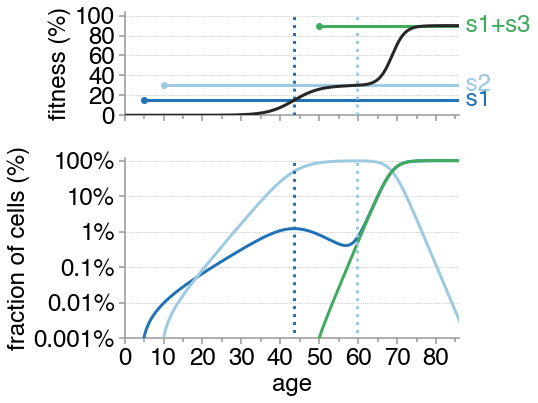

In [21]:
clones={('s1',):{'fitness':0.15, 'est_time': 4}, ('s2',):{'fitness':0.3, 'est_time':9.1}, ('s1','s3'):{'fitness':0.9, 'est_time':47.575}}
clone_trajectories, mutation_trajectories, mean_population_fitness, overall_mean_population_fitness = clone_trajectories_generator(clones, T, dt, effective_depth)
plot_trajectories(clones, clone_trajectories, mutation_trajectories, overall_mean_population_fitness, 'three_mutations')